In [80]:
import numpy as np 
import pandas as pd 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from matplotlib import pyplot as plt

In [81]:
data = pd.read_csv('KDDTrain+.txt', header = None, names=['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
            ,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root'
            ,'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login'
            ,'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
            ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
            ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
            ,'dst_host_srv_rerror_rate','attack','outcome'])

testpl = pd.read_csv('KDDTest+.txt',header = None,names=['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
            ,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root'
            ,'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login'
            ,'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
            ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
            ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
            ,'dst_host_srv_rerror_rate','attack','outcome'])

In [82]:
data = pd.concat([data,testpl],axis=0)

In [83]:
classlist = []

check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")


for item in data.pop('attack'):
    if item in check1:
        classlist.append("DoS")
    elif item in check2:
        classlist.append("Probe")
    elif item in check3:
        classlist.append("U2R")
    elif item in check4:
        classlist.append("R2L")
    else:
        classlist.append("Normal")

### Preprocessing


In [84]:
#preprocessing
#filling missing values and hot encoding
nunique = data.nunique()
types = data.dtypes
categorical_columns = []
categorical_dims =  {}
for col in data.columns:
    if types[col] == 'object':
        print(col, data[col].nunique())
        l_enc = LabelEncoder()
        print(data[col].values)
        data[col] = l_enc.fit_transform(data[col].values)
        print(data[col].values)
        categorical_columns.append(col)
        print(len(l_enc.classes_))
        categorical_dims[col] = len(l_enc.classes_)
    else:
        data.fillna(data[col].mean(), inplace=True)     #replacing the null values by mean

unused_feat = ['Set']

features = [ col for col in data.columns if col not in unused_feat ]


cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]


cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]



protocol_type 3
['tcp' 'udp' 'tcp' ... 'tcp' 'udp' 'tcp']
[1 2 1 ... 1 2 1]
3
service 70
['ftp_data' 'other' 'private' ... 'http' 'domain_u' 'sunrpc']
[20 44 49 ... 24 12 57]
70
flag 11
['SF' 'SF' 'S0' ... 'SF' 'SF' 'REJ']
[9 9 5 ... 9 9 1]
11


In [85]:
# Z score Normalization
def normalize(df, cols):
    result = df.copy() 
    for feature_name in cols:
        maxi = df[feature_name].max()
        mini = df[feature_name].min()
        if(maxi>mini):
            result[feature_name] = (df[feature_name] - mini) / (maxi-mini)
    return result

In [86]:
data = normalize(data,data.columns)
print(data['num_outbound_cmds'])
data.drop(columns=['num_outbound_cmds'], inplace=True)  

0        0
1        0
2        0
3        0
4        0
        ..
22539    0
22540    0
22541    0
22542    0
22543    0
Name: num_outbound_cmds, Length: 148517, dtype: int64


In [87]:
l_enc = LabelEncoder()
print(len(classlist))
enc_classlist = l_enc.fit_transform(classlist)
print(enc_classlist)

148517
[1 1 0 ... 0 1 2]


In [88]:
#Feature Selection
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2
skb = SelectKBest(score_func= f_regression, k=27)

            
X_new = skb.fit_transform(data, enc_classlist)
print(X_new)
featurelist=[]
for i, score in enumerate(skb.scores_):
    featurelist.append([features[i],score])

[[0.         0.5        0.28985507 ... 0.         0.         0.95238095]
 [0.         1.         0.63768116 ... 0.         0.         0.71428571]
 [0.         0.5        0.71014493 ... 1.         1.         0.9047619 ]
 ...
 [0.         0.5        0.34782609 ... 0.         0.         0.71428571]
 [0.         1.         0.17391304 ... 0.         0.         1.        ]
 [0.         0.5        0.82608696 ... 0.         0.         0.66666667]]


In [89]:
featurelist=sorted(featurelist,key=lambda x:x[1],reverse=True)
print(featurelist)


[['dst_host_serror_rate', 82081.97099106226], ['srv_count', 80997.32211012328], ['serror_rate', 80983.88619376504], ['dst_host_srv_diff_host_rate', 80874.81951640469], ['srv_rerror_rate', 68167.26497109502], ['is_guest_login', 34587.578283646435], ['dst_host_srv_count', 27483.347555715904], ['flag', 24823.601234178277], ['srv_diff_host_rate', 24352.699774648932], ['dst_host_diff_srv_rate', 23229.468206793932], ['dst_host_srv_rerror_rate', 18542.818759717036], ['dst_host_same_src_port_rate', 15420.311991145667], ['logged_in', 14304.16394104932], ['dst_host_count', 11819.617110977842], ['diff_srv_rate', 10959.294436364933], ['dst_host_same_srv_rate', 10342.387175858163], ['is_host_login', 5430.285084992203], ['same_srv_rate', 4219.046154237422], ['num_failed_logins', 3767.350737581703], ['service', 2126.717256606255], ['duration', 2044.2791874129769], ['hot', 1699.3833504541178], ['count', 1261.5053135238184], ['wrong_fragment', 1180.5431314778507], ['protocol_type', 529.279580542478], [

In [90]:
skb = SelectKBest(score_func= chi2, k=27)

            
X_new_chi2 = skb.fit_transform(data, enc_classlist)
featurelist_chi2=[]
for i, score in enumerate(skb.scores_):
    featurelist_chi2.append([features[i],score])
featurelist_chi2=sorted(featurelist_chi2,key=lambda x:x[1],reverse=True)
print(featurelist_chi2)

[['dst_host_serror_rate', 59993.634955196045], ['serror_rate', 58859.92708715819], ['srv_count', 58481.77665089952], ['dst_host_srv_diff_host_rate', 57928.29961338039], ['logged_in', 41801.90438882726], ['dst_host_count', 29517.569503770006], ['dst_host_srv_count', 27444.825295152546], ['srv_rerror_rate', 26722.42639855701], ['dst_host_diff_srv_rate', 22875.33361372113], ['dst_host_same_srv_rate', 19840.456085446865], ['rerror_rate', 18040.048711369473], ['srv_serror_rate', 18010.372862067394], ['dst_host_rerror_rate', 17918.61297178593], ['is_host_login', 17230.419639895583], ['is_guest_login', 17148.318307171132], ['root_shell', 16269.379971739685], ['same_srv_rate', 15118.975337927584], ['dst_host_srv_serror_rate', 14694.858148676924], ['diff_srv_rate', 12237.246097833824], ['dst_host_same_src_port_rate', 10130.27939408266], ['flag', 7371.135177834089], ['srv_diff_host_rate', 6738.856166018693], ['urgent', 3549.254942613723], ['num_failed_logins', 3394.9941652599946], ['num_shells',

In [91]:
# feature selection using ensemble method
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline

pipe = Pipeline([('anova', SelectKBest(f_classif, k=23)),
                 ('reduce_dim', PCA(n_components=23)),
                 ('select_features', SelectKBest(f_regression, k=23))
                 ])
data_new=pipe.fit_transform(data, enc_classlist)
print(data_new.shape)

(148517, 23)


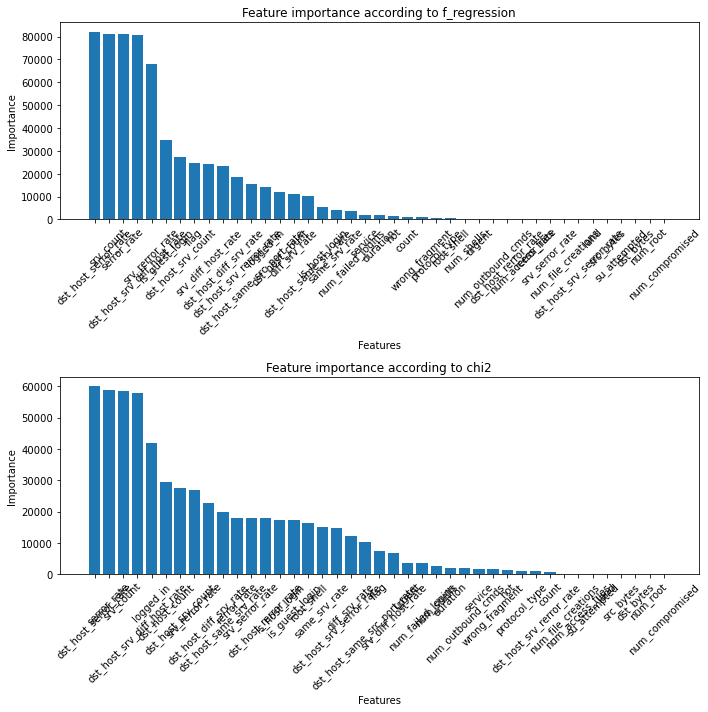

In [92]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'featurelist' and 'featurelist_chi2' are your sorted feature importance lists
f_regression_features = [i[0] for i in featurelist]
f_regression_scores = [i[1] for i in featurelist]

chi2_features = [i[0] for i in featurelist_chi2]
chi2_scores = [i[1] for i in featurelist_chi2]

# Create the figure and the axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

# On the first axis, plot the f_regression scores
axs[0].bar(f_regression_features, f_regression_scores)
axs[0].set_title('Feature importance according to f_regression')
axs[0].set_ylabel('Importance')
axs[0].set_xlabel('Features')
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)

# On the second axis, plot the chi2 scores
axs[1].bar(chi2_features, chi2_scores)
axs[1].set_title('Feature importance according to chi2')
axs[1].set_ylabel('Importance')
axs[1].set_xlabel('Features')
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

# Display the plot
plt.tight_layout()
plt.show()



In [93]:
X_train,X_test, y_train,y_test = train_test_split(data_new,np.array(classlist),test_size=0.3,random_state=14)

In [94]:
np.unique(y_train, return_counts=True)

(array(['DoS', 'Normal', 'Probe', 'R2L', 'U2R'], dtype='<U6'),
 array([37255, 54174,  9905,  2555,    72], dtype=int64))

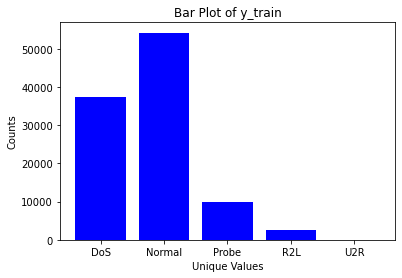

In [95]:
unique_values, counts = np.unique(y_train, return_counts=True)

# Plot the bar graph
plt.bar(unique_values, counts, color='blue')
plt.title('Bar Plot of y_train')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.show()

### All The Code Without SMOTE AND GAN

In [96]:

#Decision Tree Classifier
print("Decision Tree Classifier")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
dtree = DecisionTreeClassifier();
dtree = dtree.fit(X_train,y_train)
pred = dtree.predict(X_test)
print("The Accuracy is:")
print(accuracy_score(pred,y_test))
print(classification_report(y_test, pred))


Decision Tree Classifier
The Accuracy is:
0.9915162941018044
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      0.99      0.99     23058
       Probe       0.98      0.98      0.98      4172
         R2L       0.92      0.93      0.92      1147
         U2R       0.70      0.66      0.68        47

    accuracy                           0.99     44556
   macro avg       0.92      0.91      0.91     44556
weighted avg       0.99      0.99      0.99     44556



In [97]:
#Random Forest Classifier
print("Random Forest Classifier")
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400, random_state=42)
rfc = rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)
from sklearn.metrics import classification_report
print("The Accuracy is:")
print(rfc.score(X_test,y_test))
print(classification_report(y_test, pred))

Random Forest Classifier
The Accuracy is:
0.9958479217164916
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.99      0.99      4172
         R2L       0.96      0.95      0.95      1147
         U2R       0.82      0.57      0.68        47

    accuracy                           1.00     44556
   macro avg       0.95      0.90      0.92     44556
weighted avg       1.00      1.00      1.00     44556



In [98]:
from sklearn.linear_model import LogisticRegression


print("Logistic Regression model")
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("The Accuracy is:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test,y_pred))


Logistic Regression model


c:\Users\91797\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The Accuracy is:
0.9325118951431906
              precision    recall  f1-score   support

         DoS       0.95      0.93      0.94     16132
      Normal       0.94      0.96      0.95     23058
       Probe       0.89      0.88      0.88      4172
         R2L       0.61      0.57      0.59      1147
         U2R       0.84      0.45      0.58        47

    accuracy                           0.93     44556
   macro avg       0.85      0.76      0.79     44556
weighted avg       0.93      0.93      0.93     44556



In [99]:
from sklearn.svm import SVC

# Create an SVM model

print("SVM model")
svm = SVC()

svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)


print("The Accuracy is:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

SVM model
The Accuracy is:
0.9844016518538469
              precision    recall  f1-score   support

         DoS       0.98      1.00      0.99     16132
      Normal       1.00      0.98      0.99     23058
       Probe       0.97      0.97      0.97      4172
         R2L       0.81      0.92      0.86      1147
         U2R       0.87      0.43      0.57        47

    accuracy                           0.98     44556
   macro avg       0.93      0.86      0.88     44556
weighted avg       0.98      0.98      0.98     44556



In [100]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a GBM model

print("GBM model:")
gbm = GradientBoostingClassifier()


gbm.fit(X_train, y_train)

# Predict on test data
y_pred = gbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)
print(classification_report(y_test, y_pred));

GBM model:
0.9852545111769458
              precision    recall  f1-score   support

         DoS       0.99      0.99      0.99     16132
      Normal       0.99      0.99      0.99     23058
       Probe       0.96      0.97      0.96      4172
         R2L       0.87      0.88      0.87      1147
         U2R       0.62      0.11      0.18        47

    accuracy                           0.99     44556
   macro avg       0.89      0.79      0.80     44556
weighted avg       0.99      0.99      0.98     44556



In [101]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model

print("KNN model:")
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

KNN model:
0.9937606607415388
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.99      0.99      4172
         R2L       0.92      0.95      0.93      1147
         U2R       0.88      0.47      0.61        47

    accuracy                           0.99     44556
   macro avg       0.96      0.88      0.91     44556
weighted avg       0.99      0.99      0.99     44556



In [102]:
from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes model
print("Naive Bayes model:")
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Predict on test data
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

Naive Bayes model:
0.7908250291767663
              precision    recall  f1-score   support

         DoS       0.88      0.84      0.86     16132
      Normal       0.88      0.79      0.83     23058
       Probe       0.44      0.68      0.53      4172
         R2L       0.41      0.60      0.49      1147
         U2R       0.05      0.53      0.10        47

    accuracy                           0.79     44556
   macro avg       0.53      0.69      0.56     44556
weighted avg       0.83      0.79      0.80     44556



In [103]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a base estimator (Decision Tree)
base_estimator = DecisionTreeClassifier()

# Create a Bagging model
print("Bagging model")
bagging = BaggingClassifier(base_estimator=base_estimator)

# Fit the model to the training data
bagging.fit(X_train, y_train)

# Predict on test data
y_pred = bagging.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));


Bagging model
0.9940524284047042
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.98      0.99      4172
         R2L       0.94      0.95      0.94      1147
         U2R       0.79      0.47      0.59        47

    accuracy                           0.99     44556
   macro avg       0.94      0.88      0.90     44556
weighted avg       0.99      0.99      0.99     44556



In [104]:
from sklearn.ensemble import ExtraTreesClassifier

# Create an Extra Trees model
print("Extra trees Model")
et = ExtraTreesClassifier()

# Fit the model to the training data
et.fit(X_train, y_train)

# Predict on test data
y_pred = et.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

Extra trees Model
0.9961845767124518
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.99      0.99      4172
         R2L       0.96      0.96      0.96      1147
         U2R       0.83      0.64      0.72        47

    accuracy                           1.00     44556
   macro avg       0.96      0.92      0.93     44556
weighted avg       1.00      1.00      1.00     44556



In [105]:
from sklearn.neural_network import MLPClassifier

# Create an MLP model
mlp = MLPClassifier()
print(" MLP Classifier")
# Fit the model to the training data
mlp.fit(X_train, y_train)

# Predict on test data
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));


 MLP Classifier
0.9934240057455787
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.98      0.99      0.98      4172
         R2L       0.92      0.92      0.92      1147
         U2R       0.72      0.55      0.63        47

    accuracy                           0.99     44556
   macro avg       0.92      0.89      0.91     44556
weighted avg       0.99      0.99      0.99     44556



In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create base estimators (Decision Tree, SVM)
print("Base Estimators Using DT,SVM")
base_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC())
]

# Create a meta-classifier (Logistic Regression)
meta_classifier = LogisticRegression()

# Create a Stacking model
stacking = StackingClassifier(estimators=base_estimators, final_estimator=meta_classifier)

# Fit the model to the training data
stacking.fit(X_train, y_train)

# Predict on test data
y_pred = stacking.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

Base Estimators Using DT,SVM


c:\Users\91797\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9918080617649699
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.98      0.98      0.98      4172
         R2L       0.92      0.91      0.91      1147
         U2R       0.73      0.47      0.57        47

    accuracy                           0.99     44556
   macro avg       0.92      0.87      0.89     44556
weighted avg       0.99      0.99      0.99     44556



In [107]:

from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('knn', knn),('et',et),('svm',svm)], voting='hard')
ensemble.fit(X_train, y_train)
pred = ensemble.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print("The Accuracy is:")
print(ensemble.score(X_test,y_test))

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.99      0.99      4172
         R2L       0.93      0.96      0.95      1147
         U2R       0.88      0.45      0.59        47

    accuracy                           0.99     44556
   macro avg       0.96      0.88      0.90     44556
weighted avg       0.99      0.99      0.99     44556

The Accuracy is:
0.9949950623933926


### All code using SMOTE

In [108]:
smote = SMOTE(sampling_strategy={'R2L': 10000,'U2R':10000}, k_neighbors=4, random_state=42)

# Perform oversampling using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

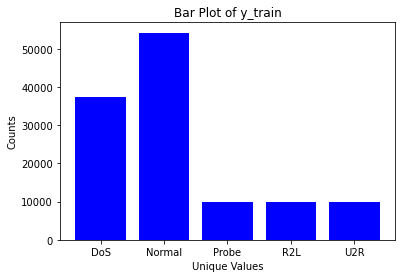

In [109]:
unique_values, counts = np.unique(y_resampled, return_counts=True)

# Plot the bar graph
plt.bar(unique_values, counts, color='blue')
plt.title('Bar Plot of y_train')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.show()  

In [110]:

#Decision Tree Classifier
print("Decision Tree Classifier")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
dtree = DecisionTreeClassifier();
dtree = dtree.fit(X_resampled, y_resampled)
pred = dtree.predict(X_test)
print("The Accuracy is:")
print(accuracy_score(pred,y_test))
print(classification_report(y_test, pred))

Decision Tree Classifier
The Accuracy is:
0.991157195439447
              precision    recall  f1-score   support

         DoS       0.99      1.00      1.00     16132
      Normal       0.99      0.99      0.99     23058
       Probe       0.98      0.98      0.98      4172
         R2L       0.93      0.92      0.93      1147
         U2R       0.60      0.60      0.60        47

    accuracy                           0.99     44556
   macro avg       0.90      0.90      0.90     44556
weighted avg       0.99      0.99      0.99     44556



In [111]:
#Random Forest Classifier
print("Random Forest Classifier")
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400, random_state=42)
rfc = rfc.fit(X_resampled, y_resampled)
pred = rfc.predict(X_test)
from sklearn.metrics import classification_report
print("The Accuracy is:")
print(rfc.score(X_test,y_test))
print(classification_report(y_test, pred))

Random Forest Classifier
The Accuracy is:
0.995937696382081
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.99      0.99      4172
         R2L       0.95      0.96      0.95      1147
         U2R       0.69      0.74      0.71        47

    accuracy                           1.00     44556
   macro avg       0.92      0.94      0.93     44556
weighted avg       1.00      1.00      1.00     44556



In [112]:
from sklearn.linear_model import LogisticRegression


print("Logistic Regression model")
logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)
y_pred = logreg.predict(X_test)

print("The Accuracy is:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test,y_pred))

Logistic Regression model


c:\Users\91797\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The Accuracy is:
0.9321303528144358
              precision    recall  f1-score   support

         DoS       0.96      0.93      0.94     16132
      Normal       0.96      0.96      0.96     23058
       Probe       0.91      0.87      0.89      4172
         R2L       0.55      0.71      0.62      1147
         U2R       0.14      0.96      0.25        47

    accuracy                           0.93     44556
   macro avg       0.70      0.88      0.73     44556
weighted avg       0.94      0.93      0.94     44556



In [113]:
from sklearn.svm import SVC

# Create an SVM model

print("SVM model")
svm = SVC()

svm.fit(X_resampled, y_resampled)


y_pred = svm.predict(X_test)


print("The Accuracy is:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

SVM model
The Accuracy is:
0.9822695035460993
              precision    recall  f1-score   support

         DoS       0.99      0.99      0.99     16132
      Normal       1.00      0.98      0.99     23058
       Probe       0.98      0.96      0.97      4172
         R2L       0.76      0.93      0.84      1147
         U2R       0.27      0.91      0.42        47

    accuracy                           0.98     44556
   macro avg       0.80      0.96      0.84     44556
weighted avg       0.99      0.98      0.98     44556



In [114]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model

print("KNN model:")
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

KNN model:
0.99358111141036
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      0.99      1.00     23058
       Probe       0.99      0.98      0.99      4172
         R2L       0.90      0.96      0.93      1147
         U2R       0.56      0.81      0.66        47

    accuracy                           0.99     44556
   macro avg       0.89      0.95      0.91     44556
weighted avg       0.99      0.99      0.99     44556



In [115]:
from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes model
print("Naive Bayes model:")
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

Naive Bayes model:
0.786022084567735
              precision    recall  f1-score   support

         DoS       0.88      0.84      0.86     16132
      Normal       0.89      0.78      0.83     23058
       Probe       0.43      0.66      0.52      4172
         R2L       0.32      0.61      0.42      1147
         U2R       0.11      0.72      0.19        47

    accuracy                           0.79     44556
   macro avg       0.52      0.72      0.56     44556
weighted avg       0.83      0.79      0.80     44556



In [116]:
from sklearn.ensemble import ExtraTreesClassifier

# Create an Extra Trees model
print("Extra trees Model")
et = ExtraTreesClassifier()

# Fit the model to the training data
et.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = et.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

Extra trees Model
0.995870365382889
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     16132
      Normal       1.00      1.00      1.00     23058
       Probe       0.99      0.99      0.99      4172
         R2L       0.95      0.96      0.95      1147
         U2R       0.65      0.74      0.69        47

    accuracy                           1.00     44556
   macro avg       0.92      0.94      0.93     44556
weighted avg       1.00      1.00      1.00     44556



In [117]:
from sklearn.neural_network import MLPClassifier

# Create an MLP model
mlp = MLPClassifier()
print(" MLP Classifier")
# Fit the model to the training data
mlp.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));


 MLP Classifier


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC

# # Create base estimators (Decision Tree, SVM)
# print("Base Estimators Using DT,SVM")
# base_estimators = [
#     ('dt', DecisionTreeClassifier()),
#     ('svm', SVC())
# ]

# # Create a meta-classifier (Logistic Regression)
# meta_classifier = LogisticRegression()

# # Create a Stacking model
# stacking = StackingClassifier(estimators=base_estimators, final_estimator=meta_classifier)

# # Fit the model to the training data
# stacking.fit(X_resampled, y_resampled)

# # Predict on test data
# y_pred = stacking.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)
# print(classification_report(y_test, y_pred));

In [ ]:

from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('knn', knn),('et',et),('svm',svm)], voting='hard')
ensemble.fit(X_resampled, y_resampled)
pred = ensemble.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print("The Accuracy is:")
print(ensemble.score(X_test,y_test))

### All Codes Using GAN

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import LeakyReLU



n_features = X_train.shape[1]

# Define the classes to oversample
classes_to_oversample = ['Probe', 'R2L', 'U2R']
epochs = 100
batch_size = 32

# Create a GAN for each class
gans = {}
for class_label in classes_to_oversample:
    # Separate the current class
    X_train_class = X_train[y_train==class_label]
    
    # Create the generator
    generator = Sequential()
    generator.add(Dense(units=32, input_dim=n_features))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=n_features, activation='tanh'))
    
    # Create the discriminator
    discriminator = Sequential()
    discriminator.add(Dense(units=32, input_dim=n_features))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Create the GAN
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    
    gans[class_label] = (generator, discriminator, gan)

# Train the GANs
for epoch in range(epochs):
    for class_label, (generator, discriminator, gan) in gans.items():
        # Generate fake instances
        noise = np.random.normal(0, 1, (batch_size, n_features))
        generated_instances = generator.predict(noise)
        
        # Get a random set of real instances
        X_train_class = X_train[y_train==class_label]
        real_instances = X_train_class[np.random.randint(0, X_train_class.shape[0], batch_size)]
        
        # Train the discriminator
        X = np.concatenate([real_instances, generated_instances])
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 1
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, n_features))
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)

# Use the generators to create synthetic instances
X_resampled = np.copy(X_train)
y_resampled = np.copy(y_train)
for class_label, (generator, _, _) in gans.items():
    num_synthetic_samples = 10000 - np.sum(y_train==class_label)
    if num_synthetic_samples > 0:
        noise = np.random.normal(0, 1, (num_synthetic_samples, n_features))
        synthetic_instances = generator.predict(noise)
        
        # Combine the synthetic instances with the original data
        X_resampled = np.concatenate([X_resampled, synthetic_instances])
        y_resampled = np.concatenate([y_resampled, [class_label]*num_synthetic_samples])

# Now, X_resampled and y_resampled are the resampled features and labels respectively


In [ ]:
unique_values, counts = np.unique(y_resampled, return_counts=True)

# Plot the bar graph
plt.bar(unique_values, counts, color='blue')
plt.title('Bar Plot of y_train')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.show()  

In [ ]:

#Decision Tree Classifier
print("Decision Tree Classifier")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
dtree = DecisionTreeClassifier();
dtree = dtree.fit(X_resampled, y_resampled)
pred = dtree.predict(X_test)
print("The Accuracy is:")
print(accuracy_score(pred,y_test))
print(classification_report(y_test, pred))


In [ ]:
#Random Forest Classifier
print("Random Forest Classifier")
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400, random_state=42)
rfc = rfc.fit(X_resampled, y_resampled)
pred = rfc.predict(X_test)
from sklearn.metrics import classification_report
print("The Accuracy is:")
print(rfc.score(X_test,y_test))
print(classification_report(y_test, pred))

In [ ]:
from sklearn.linear_model import LogisticRegression


print("Logistic Regression model")
logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)
y_pred = logreg.predict(X_test)

print("The Accuracy is:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test,y_pred))


In [ ]:
from sklearn.svm import SVC

# Create an SVM model

print("SVM model")
svm = SVC()

svm.fit(X_resampled, y_resampled)


y_pred = svm.predict(X_test)


print("The Accuracy is:")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model

print("KNN model:")
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes model
print("Naive Bayes model:")
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes model
print("Naive Bayes model:")
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Create an Extra Trees model
print("Extra trees Model")
et = ExtraTreesClassifier()

# Fit the model to the training data
et.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = et.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create an MLP model
mlp = MLPClassifier()
print(" MLP Classifier")
# Fit the model to the training data
mlp.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create base estimators (Decision Tree, SVM)
print("Base Estimators Using DT,SVM")
base_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC())
]

# Create a meta-classifier (Logistic Regression)
meta_classifier = LogisticRegression()

# Create a Stacking model
stacking = StackingClassifier(estimators=base_estimators, final_estimator=meta_classifier)

# Fit the model to the training data
stacking.fit(X_resampled, y_resampled)

# Predict on test data
y_pred = stacking.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred));

In [ ]:

from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('knn', knn),('et',et),('svm',svm)], voting='hard')
ensemble.fit(X_resampled, y_resampled)
pred = ensemble.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print("The Accuracy is:")
print(ensemble.score(X_test,y_test))